In [1]:
# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
import timm
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture (Same as training)
# ============================================================
class SSLEfficientNet(nn.Module):
    """EfficientNet backbone optimized for semi-supervised learning"""
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.5):
        super(SSLEfficientNet, self).__init__()
        
        # Load pretrained backbone
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        # Feature projector for consistency regularization
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        # Classification head with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize additional layers"""
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass with optional feature return"""
        features = self.backbone(x)
        logits = self.classifier(features)
        
        if return_features:
            projected_features = self.projector(features)
            return logits, features, projected_features
        
        return logits
    
    def extract_features(self, x):
        """Extract features without classification"""
        with torch.no_grad():
            features = self.backbone(x)
            return features

def create_ssl_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.5):
    """Create and return SSL model"""
    model = SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)
    return model

print("Model architecture defined")

Model architecture defined


In [4]:
# ============================================================
# Define Dataset and Data Loading Classes
# ============================================================
class LabeledDataset(Dataset):
    """Dataset for labeled images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            blank_img = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                blank_img = self.transform(blank_img)
            return blank_img, label, img_path

def load_datasets():
    """Load and prepare datasets"""
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir = data_dir / "labeled"
    unlabeled_dir = data_dir / "unlabeled"
    
    # Load labeled data
    labeled_paths, labels = [], []
    class_to_idx = {"Negative": 0, "Positive": 1}
    
    for class_name, class_idx in class_to_idx.items():
        class_dir = labeled_dir / class_name
        if class_dir.exists():
            for img_path in class_dir.glob("*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    labeled_paths.append(str(img_path))
                    labels.append(class_idx)
    
    print(f"Loaded {len(labeled_paths)} labeled images")
    print(f"Class distribution: {Counter(labels)}")
    
    # Split labeled data into train/validation
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    
    # Load unlabeled data
    unlabeled_paths = []
    if unlabeled_dir.exists():
        for img_path in unlabeled_dir.glob("*"):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                unlabeled_paths.append(str(img_path))
    
    print(f"Loaded {len(unlabeled_paths)} unlabeled images")
    
    return (train_paths, train_labels, val_paths, val_labels, unlabeled_paths)

print("Data loading functions defined")

Data loading functions defined


In [5]:
# ============================================================
# Load Configuration and Setup
# ============================================================
ARTIFACTS_DIR = Path("artifacts")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load configurations
with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
    data_metadata = json.load(f)
    
with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
    model_config = json.load(f)

CLASS_NAMES = ["Negative", "Positive"]  # Binary classification
IMG_SIZE = model_config["model_architecture"]["img_size"]

print(f"Evaluation setup:")
print(f"  Device: {DEVICE}")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Model: {model_config['model_architecture']['backbone']}")

Evaluation setup:
  Device: cpu
  Classes: ['Negative', 'Positive']
  Model: efficientnet_b0


In [6]:
# ============================================================
# Evaluation Functions
# ============================================================
def load_best_model():
    """Load the best trained model"""
    # Find the best model file
    model_files = list(ARTIFACTS_DIR.glob("ssl_model_best_*.pth"))
    
    if not model_files:
        raise FileNotFoundError("No trained model found. Please run training first.")
    
    # Get the most recent best model
    best_model_file = max(model_files, key=lambda x: x.stat().st_mtime)
    print(f"Loading model: {best_model_file}")
    
    # Load checkpoint
    checkpoint = torch.load(best_model_file, map_location=DEVICE)
    
    # Create model
    model = create_ssl_model(
        num_classes=model_config["model_architecture"]["num_classes"],
        model_name=model_config["model_architecture"]["backbone"],
        dropout_rate=model_config["model_architecture"]["dropout_rate"]
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)
    model.eval()
    
    print(f"Model loaded successfully")
    print(f"  Training epoch: {checkpoint['epoch'] + 1}")
    print(f"  Validation accuracy: {checkpoint['val_accuracy']:.2f}%")
    
    return model, checkpoint

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, confidence_level=0.95):
    """Calculate confidence intervals using bootstrap"""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = resample(range(n_samples), n_samples=n_samples, random_state=None)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices] if y_pred.ndim == 1 else y_pred[indices]
        
        try:
            score = metric_func(y_true_boot, y_pred_boot)
            scores.append(score)
        except:
            continue
    
    scores = np.array(scores)
    alpha = 1 - confidence_level
    lower = np.percentile(scores, (alpha/2) * 100)
    upper = np.percentile(scores, (1 - alpha/2) * 100)
    mean_score = np.mean(scores)
    
    return mean_score, lower, upper

def evaluate_model(model, data_loader):
    """Evaluate model and return predictions and probabilities"""
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in data_loader:
            images = images.to(DEVICE)
            
            # Get model outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()
            predictions = outputs.argmax(dim=1).cpu().numpy()
            
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_paths.extend(paths)
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities), all_paths

print("Evaluation functions defined")

Evaluation functions defined


In [7]:
# ============================================================
# Clinical Metrics Functions
# ============================================================
def calculate_clinical_metrics(y_true, y_proba, target_specificity=0.7):
    """Calculate clinical deployment metrics"""
    # Get probabilities for positive class
    pos_proba = y_proba[:, 1]
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, pos_proba)
    roc_auc = auc(fpr, tpr)
    
    # Find threshold that achieves target specificity
    specificity = 1 - fpr
    valid_indices = specificity >= target_specificity
    
    if np.any(valid_indices):
        best_idx = np.argmax(tpr[valid_indices])
        actual_idx = np.where(valid_indices)[0][best_idx]
        
        chosen_threshold = thresholds[actual_idx]
        achieved_sensitivity = tpr[actual_idx]
        achieved_specificity = specificity[actual_idx]
        
        # Calculate PPV and NPV at this threshold
        y_pred_binary = (pos_proba >= chosen_threshold).astype(int)
        
        # Confusion matrix components
        tn = np.sum((y_true == 0) & (y_pred_binary == 0))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        fn = np.sum((y_true == 1) & (y_pred_binary == 0))
        tp = np.sum((y_true == 1) & (y_pred_binary == 1))
        
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        
    else:
        chosen_threshold = np.nan
        achieved_sensitivity = 0.0
        achieved_specificity = 0.0
        ppv = 0.0
        npv = 0.0
    
    prevalence = np.mean(y_true)
    
    return {
        'auc': roc_auc,
        'threshold': chosen_threshold,
        'sensitivity': achieved_sensitivity,
        'specificity': achieved_specificity,
        'ppv': ppv,
        'npv': npv,
        'prevalence': prevalence,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

print("Clinical metrics functions defined")

Clinical metrics functions defined


In [8]:
# ============================================================
# Visualization Functions
# ============================================================
def plot_evaluation_results(y_true, y_proba, clinical_metrics, save_dir):
    """Create comprehensive evaluation plots"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. ROC Curve
    ax = axes[0, 0]
    ax.plot(clinical_metrics['fpr'], clinical_metrics['tpr'], 
            lw=2, label=f'ROC (AUC = {clinical_metrics["auc"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    # Mark chosen threshold
    if not np.isnan(clinical_metrics['threshold']):
        threshold_idx = np.argmin(np.abs(clinical_metrics['thresholds'] - clinical_metrics['threshold']))
        ax.scatter(clinical_metrics['fpr'][threshold_idx], clinical_metrics['tpr'][threshold_idx], 
                  color='red', s=100, zorder=5, label=f'Chosen threshold')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    ax = axes[0, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    ap_score = average_precision_score(y_true, y_proba[:, 1])
    
    ax.plot(recall, precision, lw=2, label=f'PR (AP = {ap_score:.3f})')
    ax.axhline(y=clinical_metrics['prevalence'], color='r', linestyle='--', 
              label=f'Baseline (prevalence = {clinical_metrics["prevalence"]:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision (PPV)')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Calibration Plot
    ax = axes[0, 2]
    try:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_proba[:, 1], n_bins=10, strategy='quantile'
        )
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", 
               label="Model", marker='o', markersize=8)
        ax.plot([0, 1], [0, 1], "k:", alpha=0.5, label="Perfect calibration")
        
        # Brier score
        brier_score = np.mean((y_proba[:, 1] - y_true) ** 2)
        ax.text(0.05, 0.95, f'Brier Score: {brier_score:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
    except ValueError as e:
        ax.text(0.5, 0.5, f'Calibration plot unavailable\n({str(e)})', 
               ha='center', va='center', transform=ax.transAxes)
    
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix
    ax = axes[1, 0]
    y_pred = np.argmax(y_proba, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    
    # 5. Threshold Analysis
    ax = axes[1, 1]
    specificity_curve = 1 - clinical_metrics['fpr']
    
    ax.plot(clinical_metrics['thresholds'], clinical_metrics['tpr'], 
           label='Sensitivity', linewidth=2)
    ax.plot(clinical_metrics['thresholds'], specificity_curve, 
           label='Specificity', linewidth=2)
    
    if not np.isnan(clinical_metrics['threshold']):
        ax.axvline(clinical_metrics['threshold'], color='red', linestyle='--', 
                  label=f'Chosen threshold ({clinical_metrics["threshold"]:.3f})')
    
    ax.set_xlabel('Decision Threshold')
    ax.set_ylabel('Metric Value')
    ax.set_title('Sensitivity vs Specificity')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 6. Probability Distribution
    ax = axes[1, 2]
    pos_proba = y_proba[:, 1]
    
    # Separate by true class
    neg_proba = pos_proba[y_true == 0]
    pos_proba_true = pos_proba[y_true == 1]
    
    ax.hist(neg_proba, bins=30, alpha=0.7, label=f'Negative (n={len(neg_proba)})', 
           color='blue', density=True)
    ax.hist(pos_proba_true, bins=30, alpha=0.7, label=f'Positive (n={len(pos_proba_true)})', 
           color='red', density=True)
    
    if not np.isnan(clinical_metrics['threshold']):
        ax.axvline(clinical_metrics['threshold'], color='black', linestyle='--', 
                  label=f'Decision threshold')
    
    ax.set_xlabel('Predicted Probability (Positive Class)')
    ax.set_ylabel('Density')
    ax.set_title('Probability Distribution by True Class')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_dir / "evaluation_results.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [9]:
# ============================================================
# Report Generation Functions
# ============================================================
def generate_evaluation_report(y_true, y_pred, y_proba, clinical_metrics, paths):
    """Generate comprehensive evaluation report"""
    
    # Basic classification metrics
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    # AUC with confidence intervals
    auc_mean, auc_lower, auc_upper = bootstrap_metric(
        y_true, y_proba[:, 1], roc_auc_score, n_bootstrap=1000
    )
    
    # Sensitivity and specificity with confidence intervals
    def sensitivity_func(yt, yp):
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel()
        return tp / (tp + fn) if (tp + fn) > 0 else 0
    
    def specificity_func(yt, yp):
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel()
        return tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sens_mean, sens_lower, sens_upper = bootstrap_metric(y_true, y_pred, sensitivity_func)
    spec_mean, spec_lower, spec_upper = bootstrap_metric(y_true, y_pred, specificity_func)
    
    # Error analysis
    error_mask = (y_true != y_pred)
    error_indices = np.where(error_mask)[0]
    
    error_analysis = {}
    for true_class in [0, 1]:
        for pred_class in [0, 1]:
            if true_class != pred_class:
                mask = (y_true == true_class) & (y_pred == pred_class)
                count = np.sum(mask)
                if count > 0:
                    avg_confidence = np.mean(np.max(y_proba[mask], axis=1))
                    error_analysis[f"{CLASS_NAMES[true_class]} → {CLASS_NAMES[pred_class]}"] = {
                        'count': int(count),
                        'avg_confidence': float(avg_confidence)
                    }
    
    # Compile comprehensive results
    results = {
        "model_info": {
            "architecture": model_config["model_architecture"]["backbone"],
            "num_classes": len(CLASS_NAMES),
            "ssl_enabled": True
        },
        "dataset_info": {
            "n_samples": len(y_true),
            "class_distribution": {CLASS_NAMES[i]: int(np.sum(y_true == i)) for i in range(len(CLASS_NAMES))},
            "prevalence": float(np.mean(y_true))
        },
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
        "metrics_with_ci": {
            "auc": {
                "mean": float(auc_mean),
                "ci_lower": float(auc_lower),
                "ci_upper": float(auc_upper)
            },
            "sensitivity": {
                "mean": float(sens_mean),
                "ci_lower": float(sens_lower),
                "ci_upper": float(sens_upper)
            },
            "specificity": {
                "mean": float(spec_mean),
                "ci_lower": float(spec_lower),
                "ci_upper": float(spec_upper)
            }
        },
        "clinical_thresholds": {
            "target_specificity": 0.7,
            "chosen_threshold": float(clinical_metrics['threshold']) if not np.isnan(clinical_metrics['threshold']) else None,
            "achieved_sensitivity": float(clinical_metrics['sensitivity']),
            "achieved_specificity": float(clinical_metrics['specificity']),
            "ppv": float(clinical_metrics['ppv']),
            "npv": float(clinical_metrics['npv']),
            "prevalence": float(clinical_metrics['prevalence'])
        },
        "error_analysis": {
            "total_errors": int(len(error_indices)),
            "error_rate": float(len(error_indices) / len(y_true)),
            "error_breakdown": error_analysis
        }
    }
    
    return results

def print_clinical_summary(results):
    """Print clinical deployment summary"""
    print("\n" + "="*60)
    print("CLINICAL DEPLOYMENT ASSESSMENT")
    print("="*60)
    
    metrics = results["clinical_thresholds"]
    auc_info = results["metrics_with_ci"]["auc"]
    
    print(f"Model Performance Summary:")
    print(f"  • AUC: {auc_info['mean']:.3f} [{auc_info['ci_lower']:.3f}, {auc_info['ci_upper']:.3f}]")
    print(f"  • Overall Accuracy: {results['classification_report']['accuracy']:.3f}")
    print(f"  • Error Rate: {results['error_analysis']['error_rate']:.3f}")
    
    print(f"\nClinical Deployment Recommendation:")
    if metrics['chosen_threshold'] is not None:
        print(f"  • Recommended threshold: {metrics['chosen_threshold']:.3f}")
        print(f"  • Expected sensitivity: {metrics['achieved_sensitivity']:.3f}")
        print(f"  • Expected specificity: {metrics['achieved_specificity']:.3f}")
        print(f"  • Positive Predictive Value: {metrics['ppv']:.3f}")
        print(f"  • Negative Predictive Value: {metrics['npv']:.3f}")
        
        # Clinical interpretation
        print(f"\nClinical Interpretation:")
        if metrics['achieved_sensitivity'] >= 0.8 and metrics['achieved_specificity'] >= 0.7:
            print(f"  ✓ Model meets clinical screening criteria")
            print(f"  ✓ Suitable for deployment as screening tool")
        elif metrics['achieved_sensitivity'] >= 0.9:
            print(f"  ✓ High sensitivity - good for screening")
            print(f"  ⚠ Lower specificity may increase false positives")
        else:
            print(f"  ⚠ Model may need refinement for clinical deployment")
            print(f"  ⚠ Consider additional data collection or model improvements")
        
        # PPV interpretation
        if metrics['ppv'] >= 0.5:
            print(f"  ✓ Acceptable positive predictive value")
        elif metrics['ppv'] >= 0.3:
            print(f"  ⚠ Moderate PPV - expect some false positives")
        else:
            print(f"  ⚠ Low PPV - high false positive rate expected")
        
        # NPV interpretation  
        if metrics['npv'] >= 0.95:
            print(f"  ✓ Excellent negative predictive value")
        elif metrics['npv'] >= 0.90:
            print(f"  ✓ Good negative predictive value")
        else:
            print(f"  ⚠ Consider improving sensitivity to reduce false negatives")
    
    else:
        print(f"  ⚠ Unable to achieve target specificity")
        print(f"  ⚠ Model requires significant improvement")
    
    print("="*60)

print("Report generation functions defined")

Report generation functions defined


In [10]:
# ============================================================
# Main Evaluation Pipeline
# ============================================================
def main():
    print("="*60)
    print("COMPREHENSIVE SEMI-SUPERVISED LEARNING EVALUATION")
    print("="*60)
    
    # Load trained model
    model, checkpoint = load_best_model()
    
    # Define validation transform
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    train_paths, train_labels, val_paths, val_labels, unlabeled_paths = load_datasets()
    
    # Create validation dataset and loader
    val_dataset = LabeledDataset(val_paths, val_labels, val_transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    print(f"\nEvaluation dataset:")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Class distribution: {Counter(val_labels)}")
    
    # Evaluate model
    print(f"\nEvaluating model...")
    y_true, y_pred, y_proba, paths = evaluate_model(model, val_loader)
    
    # Calculate clinical metrics
    print(f"Calculating clinical metrics...")
    clinical_metrics = calculate_clinical_metrics(y_true, y_proba, target_specificity=0.7)
    
    # Generate comprehensive report
    print(f"Generating evaluation report...")
    results = generate_evaluation_report(y_true, y_pred, y_proba, clinical_metrics, paths)
    
    # Create visualizations
    print(f"Creating visualizations...")
    plot_evaluation_results(y_true, y_proba, clinical_metrics, ARTIFACTS_DIR)
    
    # Save results
    print(f"Saving results...")
    
    # Save JSON results
    with open(ARTIFACTS_DIR / "evaluation_results.json", "w") as f:
        json.dump(results, f, indent=2, default=str)
    
    # Save detailed predictions
    predictions_df = pd.DataFrame({
        'image_path': paths,
        'true_label': y_true,
        'predicted_label': y_pred,
        'probability_negative': y_proba[:, 0],
        'probability_positive': y_proba[:, 1],
        'correct_prediction': (y_true == y_pred),
        'confidence': np.max(y_proba, axis=1)
    })
    predictions_df.to_csv(ARTIFACTS_DIR / "detailed_predictions.csv", index=False)
    
    # Print summary
    print(f"\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    
    print(f"Overall Performance:")
    print(f"  • Accuracy: {results['classification_report']['accuracy']:.3f}")
    print(f"  • AUC: {results['metrics_with_ci']['auc']['mean']:.3f} [{results['metrics_with_ci']['auc']['ci_lower']:.3f}, {results['metrics_with_ci']['auc']['ci_upper']:.3f}]")
    
    # Per-class performance
    print(f"\nPer-Class Performance:")
    for class_name in CLASS_NAMES:
        class_report = results['classification_report'][class_name]
        print(f"  {class_name}:")
        print(f"    • Precision: {class_report['precision']:.3f}")
        print(f"    • Recall: {class_report['recall']:.3f}")
        print(f"    • F1-Score: {class_report['f1-score']:.3f}")
        print(f"    • Support: {class_report['support']}")
    
    # Error analysis
    error_info = results['error_analysis']
    print(f"\nError Analysis:")
    print(f"  • Total errors: {error_info['total_errors']}/{results['dataset_info']['n_samples']} ({error_info['error_rate']:.1%})")
    if error_info['error_breakdown']:
        print(f"  • Error breakdown:")
        for error_type, error_data in error_info['error_breakdown'].items():
            print(f"    - {error_type}: {error_data['count']} cases (avg confidence: {error_data['avg_confidence']:.3f})")
    
    # Print clinical summary
    print_clinical_summary(results)
    
    # Training context if available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"\nTraining Context:")
        print(f"  • Training epochs completed: {len(history['train_loss'])}")
        print(f"  • Best validation accuracy: {max(history['val_accuracy']):.2f}%")
        print(f"  • Final training loss: {history['train_loss'][-1]:.4f}")
        print(f"  • Semi-supervised learning: {'Yes' if any(h > 0 for h in history['consistency_loss']) else 'No'}")
    
    print(f"\n" + "="*60)
    print("EVALUATION COMPLETED")
    print("="*60)
    print(f"📊 Results saved to: evaluation_results.json")
    print(f"📋 Predictions saved to: detailed_predictions.csv")
    print(f"📈 Plots saved to: evaluation_results.png")
    print(f"📁 All files saved to: {ARTIFACTS_DIR}")
    
    return results

COMPREHENSIVE SEMI-SUPERVISED LEARNING EVALUATION
Loading model: artifacts\ssl_model_best_010_78.9.pth
Model loaded successfully
  Training epoch: 10
  Validation accuracy: 78.95%
Loaded 190 labeled images
Class distribution: Counter({1: 98, 0: 92})
Training set: 152 images
Validation set: 38 images
Loaded 6377 unlabeled images

Evaluation dataset:
  Validation samples: 38
  Class distribution: Counter({1: 20, 0: 18})

Evaluating model...
Calculating clinical metrics...
Generating evaluation report...
Creating visualizations...


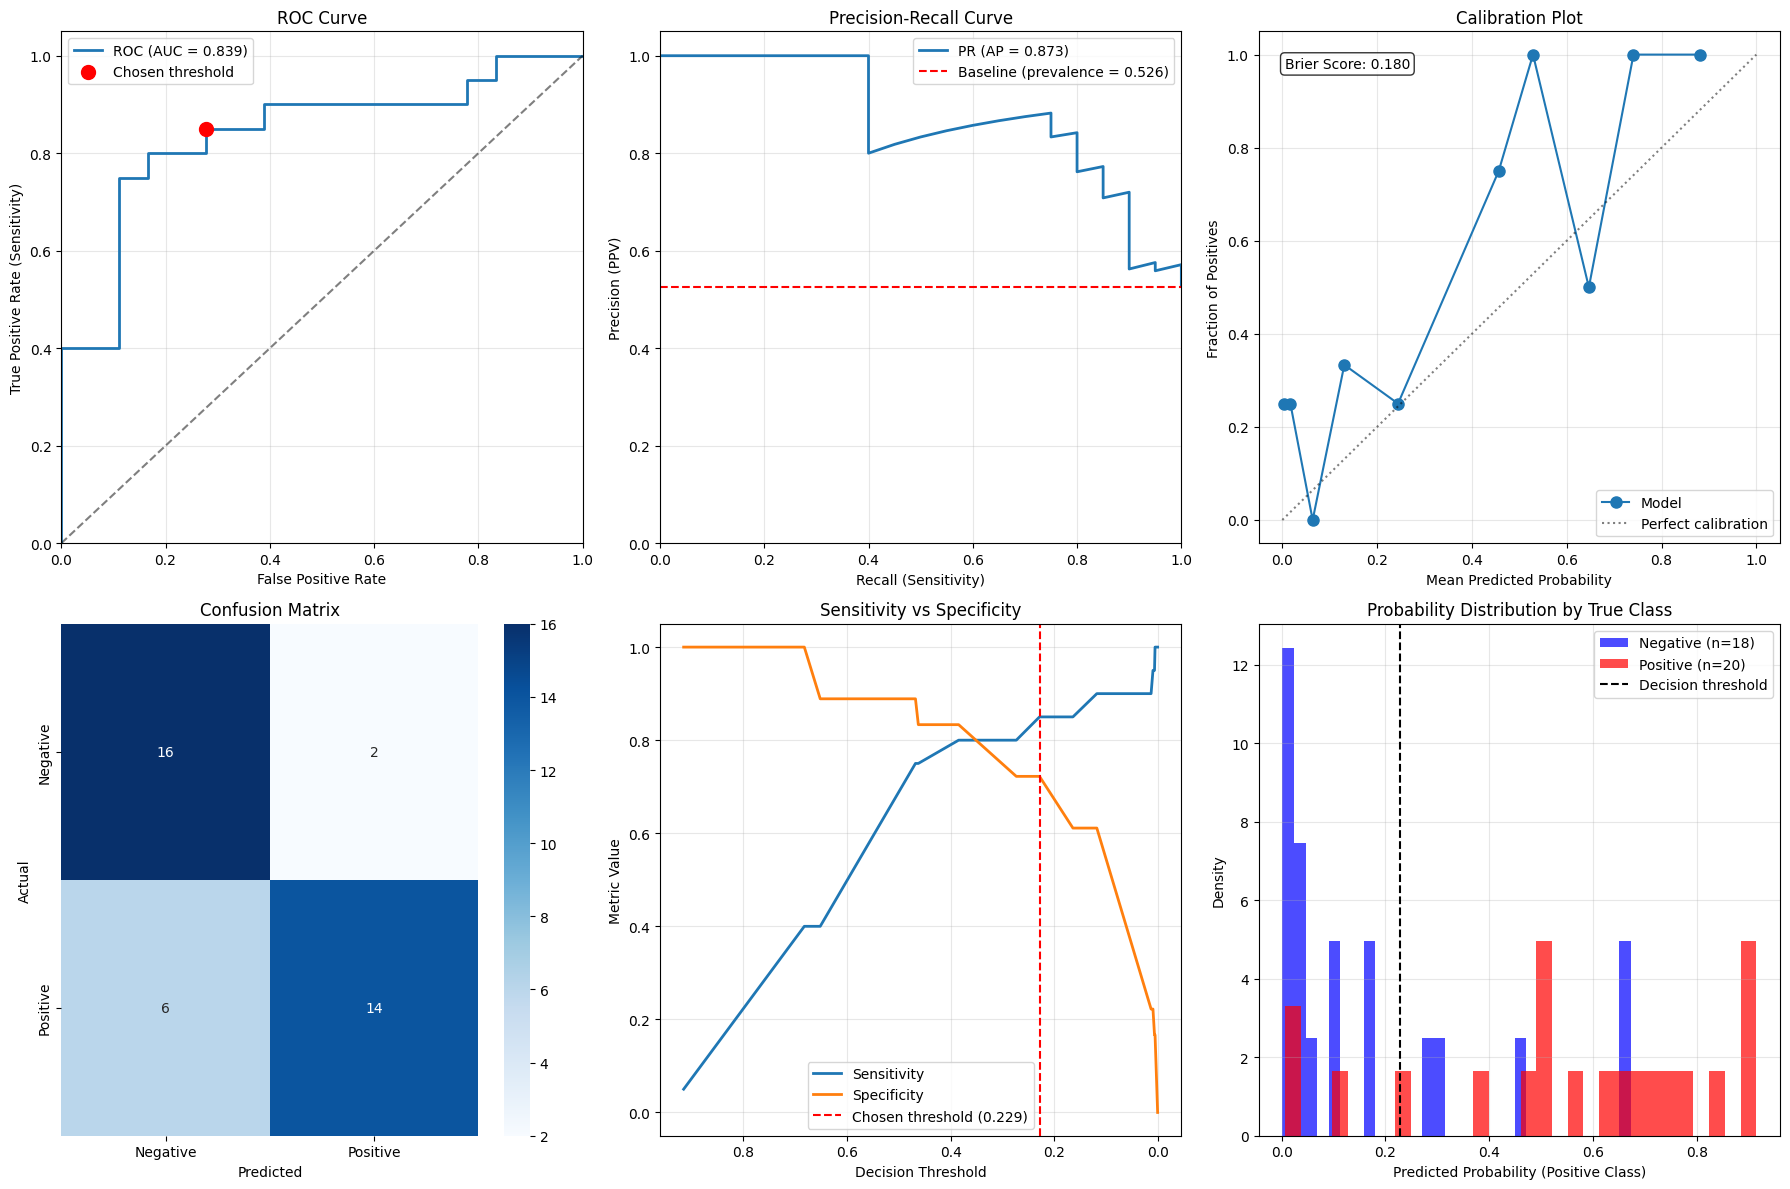

Saving results...

EVALUATION SUMMARY
Overall Performance:
  • Accuracy: 0.789
  • AUC: 0.835 [0.683, 0.953]

Per-Class Performance:
  Negative:
    • Precision: 0.727
    • Recall: 0.889
    • F1-Score: 0.800
    • Support: 18.0
  Positive:
    • Precision: 0.875
    • Recall: 0.700
    • F1-Score: 0.778
    • Support: 20.0

Error Analysis:
  • Total errors: 8/38 (21.1%)
  • Error breakdown:
    - Negative → Positive: 2 cases (avg confidence: 0.662)
    - Positive → Negative: 6 cases (avg confidence: 0.797)

CLINICAL DEPLOYMENT ASSESSMENT
Model Performance Summary:
  • AUC: 0.835 [0.683, 0.953]
  • Overall Accuracy: 0.789
  • Error Rate: 0.211

Clinical Deployment Recommendation:
  • Recommended threshold: 0.229
  • Expected sensitivity: 0.850
  • Expected specificity: 0.722
  • Positive Predictive Value: 0.773
  • Negative Predictive Value: 0.812

Clinical Interpretation:
  ✓ Model meets clinical screening criteria
  ✓ Suitable for deployment as screening tool
  ✓ Acceptable positive

In [11]:
# ============================================================
# Execute Evaluation
# ============================================================
if __name__ == "__main__":
    results = main()